In [ ]:
# FPAge
# © 2024 - Ron Raisch - HUJI
# Licensed under the FPAge License (see LICENSE file for details).
# For commercial inquiries, contact fpagedata@gmail.com

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import re
import seaborn as sns
# from dcor import distance_correlation
from glob import glob

In [2]:
# change the working directory to the root of the project
if os.path.basename(os.getcwd()) == 'Calibration':
    os.chdir('..')
    os.chdir(f'data{os.sep}calibration')
assert os.path.basename(os.getcwd()) == 'calibration', 'The working directory should be the calibration\'s data folder'

# Utilities

In [3]:
def parse_raw(df):
    df=df.reset_index()
    cols=df.columns
    df=df.drop(cols[:3],axis=1)
    df=df.drop(cols[-2:],axis=1)
    df.columns=cols[5:]
    return df

In [4]:
def parse_csv(file_name):
    _df=pd.read_csv(file_name)
    _df=_df[['M/z',' Avg Intensity']]
    _df=_df.set_index('M/z')
    _df.columns=['Intensity']
    _df.index=_df.index.astype(np.float64)
    _df=_df.sort_index()
    _df =_df['Intensity']
    _df.name=os.path.split(file_name)[-1].split('.')[0]
    return _df

In [5]:
def parse_file(file_name):
    df=pd.read_csv(file_name,sep='\t',skiprows=2,header=1)
    return parse_raw(df)

In [6]:
def parse_folder(folder_name):
    file_name=folder_name+'/imaging/Analyte 1.txt'
    df=parse_file(file_name)
    df.name=folder_name[7:-16]
    return df

In [7]:
parse_folder('initial calibration/Pixel Size/Yinon/230118_Yinon_pix100X100_pos_Slide_A_Analyte 1.raw')

,449.2546,465.2394,685.2382,481.2250,172.0595,118.1034,129.5373,284.2630,234.1531,549.3121,...,675.3328,655.1996,621.2244,429.2029,369.2890,473.2130,541.3412,637.3237,529.3135,689.3484
0,4085.0,1459.0,3443.0,523.0,4731.0,8402.0,9277.0,4410.0,5257.0,1614.0,...,127.0,187.0,327.0,520.0,977.0,477.0,292.0,157.0,162.0,86.0
1,4990.0,1538.0,3077.0,596.0,4471.0,6423.0,8755.0,4004.0,4936.0,1558.0,...,86.0,198.0,465.0,402.0,920.0,472.0,382.0,137.0,131.0,352.0
2,3892.0,1788.0,3797.0,892.0,5314.0,8354.0,9013.0,4795.0,4764.0,1423.0,...,291.0,399.0,394.0,666.0,1170.0,322.0,377.0,8.0,189.0,130.0
3,4490.0,1485.0,3157.0,612.0,4392.0,8432.0,8755.0,4213.0,4603.0,1844.0,...,143.0,116.0,402.0,867.0,1210.0,540.0,359.0,123.0,83.0,156.0
4,4181.0,1607.0,3692.0,852.0,5388.0,6989.0,8503.0,3920.0,5922.0,1570.0,...,232.0,219.0,488.0,662.0,1203.0,469.0,388.0,218.0,76.0,402.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,13219.0,7280.0,3388.0,4099.0,5501.0,5659.0,5766.0,4692.0,4045.0,1915.0,...,260.0,281.0,475.0,727.0,1026.0,538.0,349.0,164.0,350.0,193.0
196,11659.0,6737.0,3522.0,3682.0,5905.0,4952.0,5978.0,3008.0,4346.0,1279.0,...,140.0,401.0,361.0,654.0,1215.0,346.0,315.0,46.0,259.0,216.0
197,10377.0,6365.0,3410.0,3958.0,6474.0,5718.0,4830.0,4201.0,4814.0,1414.0,...,149.0,596.0,413.0,356.0,1527.0,511.0,132.0,166.0,482.0,233.0
198,9287.0,5890.0,3567.0,3931.0,5827.0,5722.0,5264.0,3749.0,4242.0,844.0,...,199.0,578.0,476.0,547.0,889.0,333.0,261.0,114.0,204.0,275.0


In [8]:
def get_spectrum(df):
    df_avg=df.mean(axis=0)
    df_avg.index=df_avg.index.astype(np.float64)
    df_avg.name=df.name
    return df_avg

In [9]:
def get_spectrum_from_folder(folder_name):
    df=parse_folder(folder_name)
    return get_spectrum(df)

In [10]:
def plot_spectrum(df_avg,num_ticks=10,ax=plt,rel_plot=True):
    max_intensity=None
    if rel_plot:
        max_intensity=df_avg.max()
        df_avg=df_avg/max_intensity*100
    
    min_val=df_avg.index.min()
    max_val=df_avg.index.max()
    dx=(max_val-min_val)/num_ticks
    # Extracting index and values from the Series
    x_values = df_avg.index
    y_values = df_avg.values
    #Plotting the Series as narrow bars using plt.plot
    ax.bar(x_values, y_values, width=1,label=df_avg.name,color='b')
    
    # Adding labels and title
    ax.set_xlabel('M/z')
    if rel_plot:
        ax.set_ylabel(f'Relative Intensity (Max Intensity={max_intensity})')
    else:
        ax.set_ylabel('Intensity')
    selected_ticks=np.arange(min_val,max_val,dx)
    # Set x-axis ticks to the selected values
    ax.set_xticks(selected_ticks)

In [11]:
def plot_folder(folder_name):
    df=get_spectrum_from_folder(folder_name)
    plot_spectrum(df)
    plt.title(os.path.split(folder_name)[-1])

In [12]:
# plot_folder('initial calibration/Pixel Size/Yinon/230118_Yinon_pix100X100_pos_Slide_A_Analyte 1.raw')

In [13]:
def get_all_raw_from_folder(root_folder,raw_files=None, go_down_tree=True):
    # extracting all .raw files in root_folder tree of files
    if raw_files is None:
        raw_files=[]
    for folder in os.listdir(root_folder):
        full_path=os.path.join(root_folder,folder)
        if folder.endswith('.raw'):
            raw_files.append(full_path)
        elif os.path.isdir(full_path) and go_down_tree:
            raw_files+=get_all_raw_from_folder(full_path,None)
    return raw_files

In [14]:
def get_pixel_size_from_folder_name(folder_name):
    # Use regular expression to extract the numeric part
    match=re.search(r'pix(\d+)X(\d+)', folder_name)
    if match:
        pix_width = int(match.group(1))
        pix_height = int(match.group(2))
        if pix_width!=pix_height:
            raise 'pixel width and height are different'
        return pix_height

In [15]:
def reduce_df(df,reduce_size=100):
    reduced_df=df.iloc[:reduce_size]
    reduced_df.name=df.name
    return reduced_df

In [16]:
def visualize_spectrum_list(spectrum_list, num_cols=2,title_method=get_pixel_size_from_folder_name,rel_plot=True):
    num_rows = len(spectrum_list) // num_cols + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 12))
    sorted_spectrum_list=sorted(spectrum_list, key=lambda x: title_method(x.name))
    
    # Flatten the axes array to simplify indexing
    axes = axes.flatten()

    # Iterate over objects and plot on each subplot
    for i, (obj, ax) in enumerate(zip(sorted_spectrum_list, axes)):
        # Call the plot_spectrum function for the current object
        plot_spectrum(obj, ax=ax, num_ticks=6,rel_plot=rel_plot)

        # Optionally, add subplot-specific labels or adjustments here
        ax.set_title(title_method(obj.name))

        # Set x-axis for each subplot
        if i >= (num_rows - 1) * num_cols:
            ax.set_xlabel("M/z")  # Replace with your x-axis label

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [17]:
def reduced_from_folder(folder,reduce_size=100):
    folder_names=get_all_raw_from_folder(folder)
    raw_list=[parse_folder(folder_name) for folder_name in folder_names]
    return [reduce_df(df,reduce_size=reduce_size) for df in raw_list]

In [18]:
def get_std(df):
    df_std=np.sqrt(df.std())
    df_std.index=df.columns.astype(np.float64)
    df_std.name=df.name
    return df_std

In [19]:
def interpolate_spectrums(df_list):
    df = pd.DataFrame(df_list).T.sort_index()
    # Define a custom grouping function
    def custom_grouping(index):
        return round(index,1)
    
    # Apply the grouping function to create a new column for grouping
    df['group'] = df.index.map(custom_grouping)
    
    # Group by the new 'group' column and sum the values within each group
    grouped_df = df.groupby('group').sum()
    grouped_df.index.name='M/z'
    return grouped_df

In [20]:
def correlation(df):
    return df.T.corr()

In [21]:
def spearman_correlation(df):
    return df.T.corr(method='spearman')

In [22]:
def distance_corr(df):
    df=df.T
    # Calculate distance correlation matrix
    distance_correlation_matrix = pd.DataFrame(index=df.columns, columns=df.columns)
    
    for i, series1 in enumerate(df.columns):
        for j, series2 in enumerate(df.columns):
            distance_correlation_matrix.loc[series1, series2] = distance_correlation(df[series1], df[series2])
    return distance_correlation_matrix.astype(np.float64)

In [23]:
def similarity_matrix(df_list,similarity_func,title_func):
    
    df=interpolate_spectrums(df_list)
    # Calculate cosine similarity matrix
    sim_matrix = similarity_func(df.T)  # Transpose the DataFrame to get series as rows
    
    # Convert the result to a DataFrame for better visualization
    sim_df = pd.DataFrame(sim_matrix, index=df.columns, columns=df.columns)
    sim_df.columns=[title_func(col) for col in sim_df.columns]
    sim_df.index=[title_func(col) for col in sim_df.index]
    
    return sim_df.sort_index().sort_index(axis=1)

In [24]:
def show_matrix(matrix,title=''):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt='.3f', linewidths=.5)
    plt.show()

In [25]:
def similarity_main_mean(folder=None,similarity_func=cosine_similarity,title_func=get_pixel_size_from_folder_name,reduce_size=100,spectrum_list=None,title=None):
    if spectrum_list is None:
        raw_list=reduced_from_folder(folder,reduce_size=reduce_size)
        spectrum_list=[get_spectrum(df) for df in raw_list]
    sim_matrix=similarity_matrix(spectrum_list,similarity_func,title_func)
    try:
        sim_matrix.index=sim_matrix.index.astype(np.int64)
        sim_matrix.columns=sim_matrix.columns.astype(np.int64)
    except:
        pass
    sim_matrix=sim_matrix.sort_index()
    sim_matrix=sim_matrix.T.sort_index().T
    if title is None and folder is None:
        show_matrix(sim_matrix,f'Mean {similarity_func.__name__}')
    elif title is None:
        show_matrix(sim_matrix,f'Mean {similarity_func.__name__} for {os.path.split(folder)[-1]}')
    else:
        show_matrix(sim_matrix,title)

In [31]:
def similarity_main(folder=None,similarity_func=cosine_similarity,title_func=get_pixel_size_from_folder_name,reduce_size=100,spectrum_list=None,title=None,show_std=False):
    if folder is not None:
        raw_list=reduced_from_folder(folder,reduce_size=reduce_size)
        spectrum_list=[get_spectrum(df) for df in raw_list]
        if show_std:
            std_df=[get_std(df) for df in raw_list]
    mean_matrix=similarity_matrix(spectrum_list,similarity_func,title_func)
    try:
        mean_matrix.index=mean_matrix.index.astype(np.int64)
        mean_matrix.columns=mean_matrix.columns.astype(np.int64)
    except:
        pass
    finally:
        mean_matrix=mean_matrix.sort_index()
        mean_matrix=mean_matrix.T.sort_index().T
        if folder is not None:
            show_matrix(mean_matrix,f'Mean {similarity_func.__name__} for {os.path.split(folder)[-1]}')
            if show_std:
                std_matrix=similarity_matrix(std_df,similarity_func,title_func)
                show_matrix(std_matrix,f'STD {similarity_func.__name__} for {os.path.split(folder)[-1]}')
        else:
            show_matrix(mean_matrix,f'Mean {similarity_func.__name__}')

In [32]:
def visualize_spectrum_from_folder(folder, spectrum_type='mean',title_method=get_pixel_size_from_folder_name,rel_plot=True):
    reduced_df = reduced_from_folder(folder)
    spectrum_list = None
    if spectrum_type == 'mean':
        spectrum_list = [get_spectrum(df) for df in reduced_df]
    elif spectrum_type == 'std':
        spectrum_list = [get_std(df) for df in reduced_df]
    else:
        raise ValueError('spectrum_type must be in [mean, std]')

    visualize_spectrum_list(spectrum_list,title_method=title_method,rel_plot=rel_plot)

# Pixel Size

In [33]:
_=os.listdir('initial calibration/Pixel Size/Yinon')
_.sort()
_

['.ipynb_checkpoints',
 '230118_Yinon_pix020X020_pos_Slide_A_Analyte 1.raw',
 '230118_Yinon_pix030X030_pos_Slide_A_Analyte 1.raw',
 '230118_Yinon_pix050X050_pos_Slide_A_Analyte 1.raw',
 '230118_Yinon_pix100X100_pos_Slide_A_Analyte 1.raw',
 '230118_Yinon_pix200X200_pos_Slide_A_Analyte 1.raw']

In [34]:
# visualize_spectrum_from_folder('initial calibration/Pixel Size/Yinon')

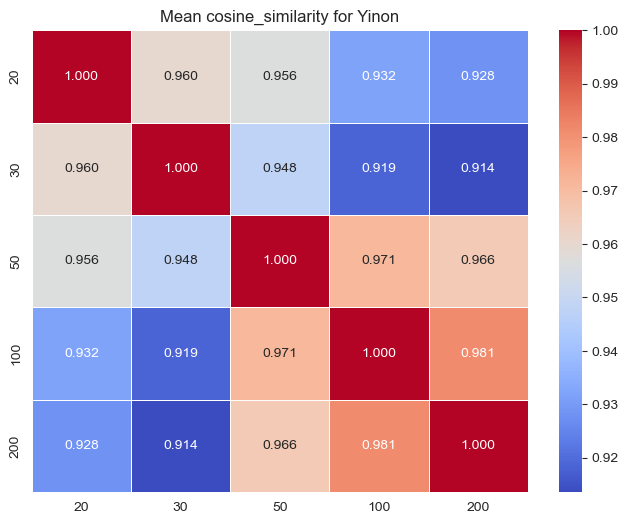

In [35]:
similarity_main('initial calibration/Pixel Size/Yinon')

In [36]:
# similarity_main('initial calibration/Pixel Size/Yinon',similarity_func=correlation)

In [37]:
# similarity_main('initial calibration/Pixel Size/Yinon',similarity_func=spearman_correlation)

In [38]:
# similarity_main('initial calibration/Pixel Size/Yinon',similarity_func=distance_corr)

# Rate

In [39]:
def get_rate_from_folder_name(folder_name):
    # Use regular expression to extract the numeric part
    match=re.search(r'rate(\d+)', folder_name)
    if match:
        return int(match.group(1))

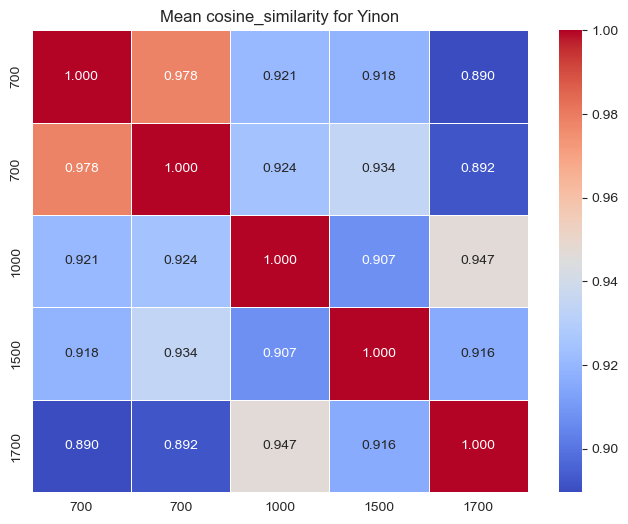

In [40]:
similarity_main('initial calibration/Rate analysis/Yinon',title_func=get_rate_from_folder_name)

In [41]:
# similarity_main('initial calibration/Rate analysis/Yinon',title_func=get_rate_from_folder_name,similarity_func=correlation)

In [42]:
inon_folder_names=get_all_raw_from_folder('initial calibration/Rate analysis/Yinon')
inon_spectrums=[get_spectrum_from_folder(folder) for folder in inon_folder_names]

In [43]:
# visualize_spectrum_list(inon_spectrums,title_method=get_rate_from_folder_name)

# Amount of pixels

In [44]:
full_sample=parse_folder('initial calibration/Rate analysis/Yinon/230118_Yinon_rate1700_pos_Slide_A_Analyte 1.raw')

In [45]:
amount_of_pixels2check=[50,100,150,200,300,400,500,600,700,800]

In [46]:
def reduce_amount(df,amount):
    amount_df=df.iloc[:amount]
    amount_df.name=str(amount)
    return amount_df

In [47]:
check_amount_list=[reduce_amount(full_sample,amount) for amount in amount_of_pixels2check]

In [48]:
check_amount_spectrum=[get_spectrum(df) for df in check_amount_list]

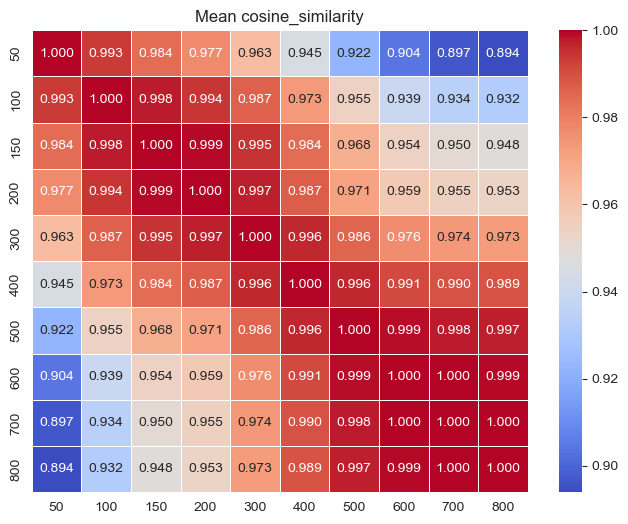

In [49]:
similarity_main(spectrum_list=check_amount_spectrum,title_func=lambda x:x)

In [50]:
sim_mat=similarity_matrix(check_amount_spectrum,similarity_func=cosine_similarity,title_func=lambda x:x)

In [51]:
sim_ref_800=sim_mat['800']

In [52]:
sim_ref_800.index=sim_ref_800.index.astype(np.int64)
sim_ref_800=sim_ref_800.sort_index()

Text(0.5, 1.0, 'Rate 1.7 mm/s, ref. to 800 Pixels')

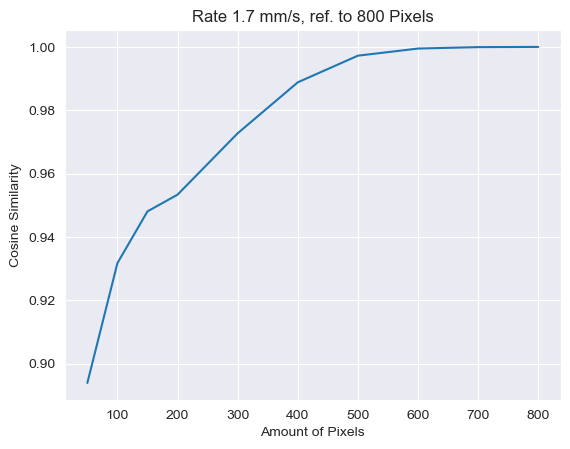

In [53]:
plt.plot(sim_ref_800)
plt.grid(True)
plt.xlabel('Amount of Pixels')
plt.ylabel('Cosine Similarity')
plt.title('Rate 1.7 mm/s, ref. to 800 Pixels')

# tape comparison - Consistancy test

In [59]:
tape_files_names=glob('06_03_23/different tapes/*.csv')

In [60]:
def parse_csv(file_name):
    _df=pd.read_csv(file_name)
    _df=_df[['M/z',' Avg Intensity']]
    _df=_df.set_index('M/z')
    _df.columns=['Intensity']
    _df.index=_df.index.astype(np.float64)
    _df=_df.sort_index()
    _df=_df['Intensity']
    _df.name=file_name
    return _df

In [61]:
tape_spectrums=[parse_csv(file_name) for file_name in tape_files_names]

In [62]:
def get_tape_name(file_name):
    match=re.search(r'/tape(\w)', file_name)
    if match:
        return 'tape '+match.group(1)

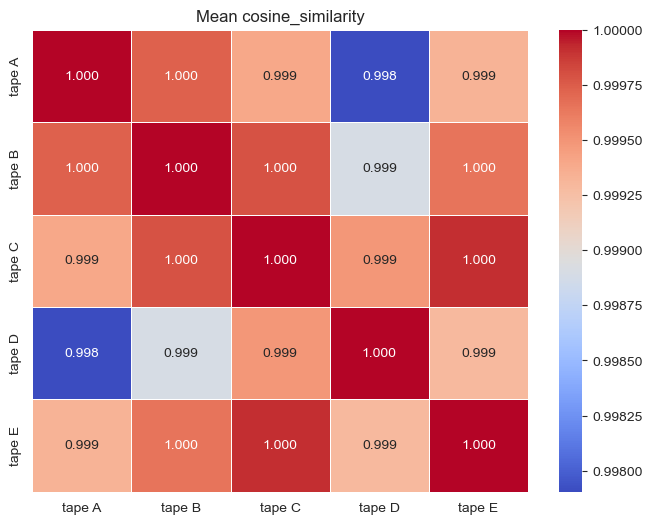

In [63]:
similarity_main(spectrum_list=tape_spectrums,title_func=get_tape_name)

# Powder consistency

In [71]:
clean_powder_spectrums=[parse_csv(file_name) for file_name in glob('23_11_20/powder_clean/*.csv')]
no_clean_powder_spectrums=[parse_csv(file_name) for file_name in glob('23_11_20/powder_no_clean/*.csv')]
fp_powder_spectrums=[parse_csv(file_name) for file_name in glob('23_11_20/Yinon_powder_no_clean/*.csv')]

In [72]:
# no_clean_powder_spectrums[0]/no_clean_powder_spectrums[0].sum()

In [73]:
empty_norm_spectrums=[spectrum/spectrum.sum() for spectrum in no_clean_powder_spectrums]

In [74]:
def get_powder_name(file_name):
    return file_name[0]

In [75]:
# similarity_main_mean(spectrum_list=empty_norm_spectrums,title_func=get_powder_name,title='Empty Powder Tapes Similarity (normalized)')

In [76]:
# visualize_spectrum_list(no_clean_powder_spectrums,rel_plot=True,title_method=get_powder_name)

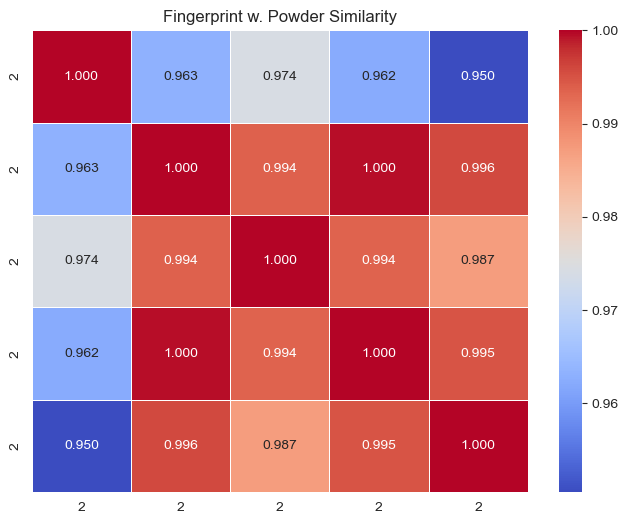

In [77]:
similarity_main_mean(spectrum_list=fp_powder_spectrums,title_func=get_powder_name,title='Fingerprint w. Powder Similarity')

In [78]:
mean_powder=interpolate_spectrums(empty_norm_spectrums).sum(axis=1)

In [79]:
# fig, axes = plt.subplots(1,1)
# plot_spectrum(mean_powder/mean_powder.sum(),rel_plot=False,ax=axes)
# plt.title('Background Noise Pattern from Powder and Tape')
# plt.ylabel('Normalized Value')

In [80]:
# visualize_spectrum_list(no_clean_powder_spectrums,rel_plot=True,title_method=get_powder_name)

In [81]:
powder_constant=1000
fp_wo_powder=(interpolate_spectrums(fp_powder_spectrums).T -powder_constant* mean_powder).dropna(how='all',axis=1)

In [82]:
fp_wo_powder_pos=fp_wo_powder[fp_wo_powder>0].dropna(how='any',axis=1)

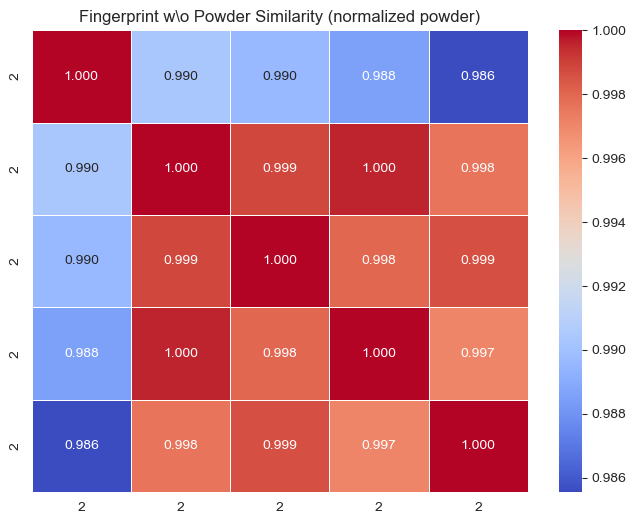

In [83]:
similarity_main_mean(spectrum_list=fp_wo_powder_pos,title_func=get_powder_name,title='Fingerprint w\o Powder Similarity (normalized powder)')

# fp/swipe/slide

In [84]:
homo_folders_names=get_all_raw_from_folder('initial calibration',go_down_tree=False)

In [85]:
def get_homo_title(file_name):
    match=re.search(r'/(\d+)_([a-zA-Z]+)_([a-zA-Z]+)', file_name)
    if match:
        first_word=match.group(2)
        sec_word=match.group(3)
        return first_word+' '+sec_word

In [86]:
homo_spectrums=[get_spectrum_from_folder(folder) for folder in homo_folders_names]

In [87]:
# visualize_spectrum_list(homo_spectrums,title_method=get_homo_title)

In [88]:
# homo_folders_names

In [89]:
male_homo_score=similarity_matrix(df_list=homo_spectrums[1:3],similarity_func=cosine_similarity,title_func=get_homo_title).iloc[0,1]

In [90]:
female_homo_score=similarity_matrix(df_list=[homo_spectrums[0],homo_spectrums[3]],similarity_func=cosine_similarity,title_func=get_homo_title).iloc[0,1]

In [91]:
print(f'Female Homogeneous Score: {female_homo_score}')
print(f'Male Homogeneous Score: {male_homo_score}')

Female Homogeneous Score: 0.9845488587206506
Male Homogeneous Score: 0.9030374961924456


In [92]:
# similarity_main(spectrum_list=[homo_spectrums[0],homo_spectrums[1],homo_spectrums[-1]],title_func=get_homo_title)